# Side-Channel Analysis Lab 02: Leakage Analysis Tools

- *Course*: ISMIN, "Théorie et pratique des attaques par observation"
- *Year*: 2023
- *Initial Author*: [Thomas Hiscock](mailto:thomas.hiscock@cea.fr), CEA-LETI (LTSO Laboratory)
- *Modified by*: [Arsene Baert](arsene.baert@etu.emse.fr) et [Michely PEREIRA](michelly.pereira@etu.emse.fr)

In this tutorial, we will perform some basic leakage analysis on side-channel traces.
We will work on traces obtained  with an STM32 processing AES on different plain test.

Notes :
ajouter bruit + desynchronisation (évite que les astres soit bien allignés, on vient volontairement créer de la désyncrhonysation dans la courbe, on vérifie à partir de quand la désynchronisation est suffisante pour tomber en dessous de 0.78 à 0.2, le problème est de faire qq chose de vraiment aléatoire donc on peut avoir de la répététivité et ainsi apprendre sur nos trace désynchronisé, rajouter des 0 au début)
On veut mesurer l'efficacité de la désynchronisation 
On peut ajouter du masquage
Attention il faut d'abord s'assurer que la clef n'est plus disponible en clair donc d(Pt xor k* xor M)

## Introduction
Les canaux cachés sont une catégorie d'attaques de sécurité cryptographique qui exploitent les informations non intentionnelles divulguées par un dispositif lors du traitement d'informations secrètes. Ces attaques peuvent être basées sur des mesures de puissance, par exemple l'analyse de puissance de corrélation (CPA) sur \cite{cema}, de courant, de signal électromagnétique et d'autres signaux physiques produits par l'appareil lorsqu'il traite une information.

Dans ce TP, notre attaque est basée sur les mesure et analyse statique du rayonnement électromagnétique (EM) en mode boîte blanche dans le contexte de la Correlation Eletro-Magnetique Analysis (CEMA), une technique de canaux cachés qui utilise ces mesures pour identifier des informations secrètes, telles que des clés cryptographiques. Dans le cas de la CEMA, l'attaquant collecte les mesures électromagnétiques de l'appareil pendant le traitement cryptographique et les analyse pour identifier les corrélations entre les mesures et les données secrètes. Ces corrélations sont ensuite utilisées pour déduire des informations secrètes, telles que des clés cryptographiques.

AES (Advanced Encryption Standard) est un algorithme de cryptage à clé symétrique considéré comme sécurisé et utilisé dans plusieurs applications, par exemple dans le protocole de sécurité Wi-Fi. Nous savons qu'un chiffrement symétrique est basé sur une seule clé secrète qui est utilisée à la fois pour chiffrer et déchiffrer les données. Cette clé doit donc être très bien protégée et ne pas tomber entre de mauvaises mains. Dans ce contexte, notre objectif sera de trouver la valeur de la clé d'un AES en utilisant la méthode CEMA expliquée ci-dessus et avec les outils logiciels et matériels fournis.



## Méthodologie

Notre méthodologie est composée de 4 étapes : l'acquisition et le traitement du signal électromagnétique, l'attaque pour récupérer la valeur de chaque octet de la clé de l'AES, le développement d'une contre-mesure qui consiste à désynchroniser l'onde analysée et enfin le test fonctionnel de cette contre-mesure, où nous vérifierons si nous pouvons toujours trouver la valeur de la clé.

![Methodologie](methodologie.png)
**Figure 1** - Methodologie suite

## Acquisition des trames
```C
if (i == 0) {
    GPIO_SetBits(GPIOB, GPIO_Pin_8);
    subBytes();
    GPIO_ResetBits(GPIOB, GPIO_Pin_8);
}
```
<img src="Figures/cible.jpg"  width="600">

**Figure 2** - Cible


## Construction des hypothèses de clé

<img src="Figures/operation.png"  width="400">

**Figure 3** - Cible

## Imports

In [10]:
import collections

import numpy as np
import matplotlib.pyplot as plt
from utils import hamming_weight, aes_sbox


## Load Traces
We load our traces stored in csv in a numpy array.


In [12]:
# For csv
full_trace_em = np.empty((0, 2504))

for i in range(1,301):  # Repeat for our 300 traces    
    i_str = str(i)
    file_name = "../../Data/Trace_csv/20230130-0001 (" + i_str  + ").csv"
    full_trace_em_str = np.loadtxt(file_name, dtype=str, delimiter=';', skiprows=3)
    full_trace_em_str = full_trace_em_str[:,1]  # The first column contain time data but is not relevant because each point is ordered by time (first point first gathered)
    full_trace_em_str = np.char.replace(full_trace_em_str, ',', '.')  # Our data collection program used comas instead of points
    full_trace_em_str = np.char.replace(full_trace_em_str, 'âˆž', '100')  # When a saturation on our data was recorded (>100mV or <100mv), it was replaced by an infinite signed, written âˆž in str, we replace it by 100
    trace_em = full_trace_em_str.astype(float)  # Transform our str type data to float
    full_trace_em = np.row_stack((full_trace_em, trace_em))

print(full_trace_em)
print(np.shape(full_trace_em))

[[ -3.949311    0.7874015  -7.898622  ...  -7.108144  -33.17852
  -29.22613  ]
 [ -6.317667    0.7874015  -3.158834  ...  -7.108144  -30.80709
  -33.96592  ]
 [  8.689098   -1.577879   -2.368356  ... -10.26698   -22.11799
  -37.9183   ]
 ...
 [ 12.63841    -2.368356   -3.158834  ... -16.58772   -16.58772
  -37.9183   ]
 [ -2.368356   -0.7874015  -5.52719   ...  -6.317667  -33.96592
  -31.59756  ]
 [  0.         -1.577879   -1.577879  ...  -7.108144  -26.0673
  -37.12783  ]]
(300, 2504)


## Example of trace

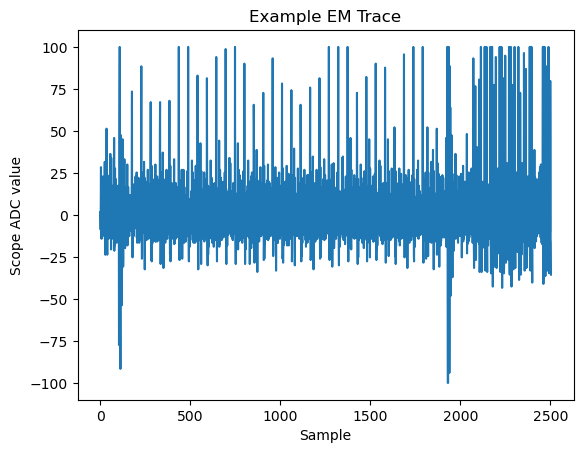

In [13]:
plt.plot(full_trace_em[29])
plt.xlabel("Sample")
plt.ylabel("Scope ADC value")
plt.title("Example EM Trace")
plt.show()

## Load plain text

In [14]:
file_name = "../../Data/pText.txt"
p_texts = np.loadtxt(file_name, dtype=str)
p_texts[0][:2]
print(p_texts, np.shape(p_texts))

['3633f1e7147bc067445d6b5de5677bd4' '18d46a264e121a4ba23319b52cd25370'
 'b1d67c63b5c9bc79005b59025c9748d4' ... '97388406ea5d1916380313a25ace3514'
 'b82ff45942f4a70ef5a740068b16719d' 'b0127e0fdeeb2b96acf8d60ff4210b55'] (5000,)


## Implementation of our model
Our model will replicate the functionment of the SubBytes function in AES and calculate the Hamming weight of the result. It will take in argument the first byte of the plain text and a byte respresenting one byte of our key.

In [20]:
SBOXFile = open("../../Data/sbox_dec.txt", "r")

SBox = np.zeros(256, dtype=np.int32)

for i in range(256):
    SBox[i] = SBOXFile.readline()[:-2]

def model(p_text_byte, k_byte):
    return hamming_weight(aes_sbox(k_byte ^ p_text_byte))

def gen_array_hm(p_text):
    hyp_array = np.zeros((256, 300), dtype=int)
    for i in range(256):
        for j in range(300):
            hyp_array[i][j] = model(int(p_text[j][0:2], 16), i)
    return hyp_array

def gen_arra_corr(hyp_array):
    correlation_array = np.empty((256, 2504))
    for i in range(256):
        for j in range(2504):
            correlation_array[i, j] = np.corrcoef(hyp_array[i], full_trace_em[:,j])[0, 1]
    return correlation_array

def get_max_pos(array):
    max = 0
    for i in range(np.shape(array)[0]):
        for j in range(np.shape(array)[1]):
            if (max < abs(array[i,j])):
                max = abs(array[i,j])
                max_pos = i
    return max_pos
    

hm_array = gen_array_hm(p_texts)
corr_array = gen_arra_corr(hm_array)
pos_max_corr = get_max_pos(corr_array)
print(hm_array, np.shape(hm_array))
print(corr_array, np.shape(corr_array))
print(pos_max_corr)

C:\Users\arsen\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\arsen\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[[2 5 3 ... 3 5 2]
 [4 4 6 ... 3 1 4]
 [2 3 5 ... 2 4 2]
 ...
 [5 5 3 ... 1 3 5]
 [4 4 2 ... 4 2 4]
 [6 3 5 ... 5 3 6]] (256, 300)
[[ 0.03955531  0.02995192  0.05218788 ... -0.02085311  0.03050886
  -0.03763064]
 [ 0.08517639 -0.08564208  0.04220008 ... -0.05710098  0.03944862
   0.00202426]
 [-0.01543629 -0.01375074 -0.04660001 ... -0.02815752 -0.0259961
   0.0647495 ]
 ...
 [-0.04094547  0.03385958 -0.03763128 ...  0.09551446 -0.07429015
  -0.00041072]
 [ 0.06633301 -0.05861013  0.0531563  ...  0.0030902  -0.07092806
   0.06347632]
 [ 0.06545647 -0.06638703 -0.02785756 ... -0.07278937  0.08458598
  -0.06020519]] (256, 2504)
23
